# OPTIMIZATION

## Problem Overview
Equity money management strategies are largely classified as either ‘active’ or ‘passive’. The most common passive strategy is that of “indexing” where the goal is to choose a portfolio that mirrors the movements of the broad market population or a market index. Such a portfolio is called an index fund. For example, the QQQ Index fund tracks the NASDAQ-100 index.

Constructing an index fund that tracks a specific broad market index could be done by simply purchasing all n stocks in the index, with the same weights as in the index. However, this approach is impractical (many small positions) and expensive (rebalancing costs may frequently be incurred, price response to trading). An index fund with m stocks, where m is substantially smaller than the size of the target population, n, seems desirable.

In this project, we will create an Index fund with m stocks to track the NASDAQ-100 index. We will do this in multiple steps. First, we will formulate an integer program that picks exactly m out of n stocks for our portfolio. This integer program will take as input a ‘similarity matrix’, which we will call $\rho$. The individual elements of this matrix, $\rho_{ij}$ , represent similarity between stock i and j. An example of this is the correlation between the returns of stocks i and j. But one could choose other similarity metrics $\rho_{ij}$.

Next, you will solve a linear program to decide how many of each chosen stock to buy for your portfolio and finally evaluate how well your index fund does as compared to the NASDAQ-100 index, out of sample. You will examine the performance for several values of m.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
import copy

In [2]:
# This represents a maximum time in seconds for a process or operation 
timeLimit = 3600

In [3]:
# Read csv
stock19 = pd.read_csv('stocks2019new.csv')  # for portfolio construction
stock20 = pd.read_csv('stocks2020new.csv')  # for performance analysis
stocks_2019 = copy.deepcopy(stock19)
stocks_2020 = copy.deepcopy(stock20)

In [4]:
# Organize the dataframe
stock19['X'] = pd.to_datetime(stock19['X'])
stock20['Unnamed: 0'] = pd.to_datetime(stock20['Unnamed: 0'])

In [5]:
# Reset index
stock19 = stock19.set_index('X')
stock20 = stock20.set_index('Unnamed: 0')

In [6]:
return19 = stock19.pct_change()  # returns for stocks in 2019
return20 = stock20.pct_change()  # returns for stocks in 2020

In [7]:
return19.head(5)

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,AMZN,AMGN,ADI,ANSS,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.033602,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.025242,-0.015216,-0.060405,-0.037550,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.044824,0.039903,0.048632,0.114370,0.057779,0.010445,0.050064,0.034184,0.024278,0.043737,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.010211,0.028196,0.013573,0.082632,0.018302,0.017192,0.034353,0.013457,0.006288,0.025477,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.009802,0.030309,0.014918,0.008751,0.006207,0.015954,0.016612,0.012824,0.024396,0.004955,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051


In [8]:
return20.head(5)

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,AMZN,AMGN,ADI,ANSS,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.008827,0.000341,-0.007834,-0.010183,-0.013260,-0.011421,-0.012139,-0.006789,-0.017604,-0.010093,...,-0.021369,-0.017207,0.021095,0.009728,-0.006699,0.000000,0.005852,-0.015392,0.004809,-0.023020
2020-01-06,0.006211,0.018238,0.005726,-0.004321,0.001598,0.019398,0.014886,0.007674,-0.011749,-0.009262,...,-0.013543,0.003118,0.009259,0.002294,0.027755,0.008632,0.006234,-0.019192,-0.001436,-0.020844
2020-01-07,-0.000234,0.010043,-0.000959,-0.002893,0.002533,-0.009864,0.002092,-0.009405,0.022751,0.008170,...,0.045951,0.008528,0.002318,0.008369,-0.001071,-0.005035,0.020414,0.067698,-0.002077,0.022830
2020-01-08,0.007452,-0.007623,0.013438,-0.008705,0.016191,0.010386,-0.007809,0.000756,0.009032,0.004130,...,-0.012323,0.019400,0.004626,0.009208,0.032620,-0.058357,0.033304,0.014484,-0.000961,-0.002815


# Question 1

## Stock selection
**Decision Variables**

1. $y_j$ : whether stock 'j' is selected in the portfolio or not (1 if j selected in the fund, 0 otherwise)

2. $x_{ij}$ : is $i^{th}$ stock found to be most similar to $j^{th}$ stock ($x_{ij}$ = 1 if stock j in index is the most similar stock i, 0 otherwise)


$\rho_{ij}$ represents similarity between stock i and j.


objective
$$\max_{x,y}\sum_{i=1}^n \sum_{j=1}^n \rho_{ij}x_{ij}$$

constraints
1. Exactly m stocks in the fund
2. Each stock $i$ has exactly one representative stock $j$ in the index
3. Stock $i$ is represented by $j$ only and only if $j$ is in the fund
$$\sum_{j=1}^n y_j=m$$
$$\sum_{j=1}^n x_{ij}=1 (i=1,2,...,n)$$
$$x_{ij}\leq y_j (i,j = 1,2,...,n)$$ 
$$x_{ij},y_j \in \{0,1\}$$

In [9]:
# Correlation matrix for returns (this will be the coefficients in the objective function)
rho = return19.drop(columns='NDX').corr()
rho.head(5)

,ATVI,ADBE,AMD,ALXN,ALGN,AMZN,AMGN,ADI,ANSS,AAPL,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.000000,0.399818,0.365460,0.223037,0.216119,0.475718,0.203726,0.329290,0.384252,0.432056,...,0.322576,0.127818,0.464658,0.316466,0.259172,0.218135,0.311244,0.303645,0.043306,0.249506
ADBE,0.399818,1.000000,0.452099,0.368788,0.362938,0.606390,0.291287,0.473446,0.733867,0.507247,...,0.359661,0.201066,0.710876,0.540772,0.401603,0.227890,0.650442,0.361612,0.208674,0.288903
AMD,0.365460,0.452099,1.000000,0.300928,0.343758,0.559990,0.150255,0.503236,0.491232,0.497625,...,0.332202,0.210641,0.497964,0.329417,0.272276,0.282588,0.407215,0.438964,0.018335,0.477657
ALXN,0.223037,0.368788,0.300928,1.000000,0.332155,0.376147,0.341036,0.316472,0.407382,0.316872,...,0.256723,0.408762,0.350600,0.189353,0.521961,0.194266,0.415600,0.290663,0.048108,0.199977
ALGN,0.216119,0.362938,0.343758,0.332155,1.000000,0.406671,0.264115,0.327912,0.370638,0.358777,...,0.175487,0.128412,0.360553,0.251167,0.334632,0.219793,0.308633,0.284442,0.088566,0.253583


In [10]:
m = 5 # Find the best 5 stocks to represent index
n = len(rho.columns) # n = number of stocks
n

97

In [11]:
# Set optimization model
mod = gp.Model()

# Decision Variables, Total decision variables = n * n + n
modX = mod.addMVar((n,n), vtype='B')
modY = mod.addMVar(n, vtype='B')

# Objective Function
mod.setObjective(gp.quicksum(gp.quicksum(modX[i][j] * rho.iloc[i, j] for i in range(n)) for j in range(n)), sense=gp.GRB.MAXIMIZE)

# Constraints
con1 = mod.addConstr(gp.quicksum(modY[j] for j in range(n)) == m)
con2 = mod.addConstrs(gp.quicksum(modX[i][j] for j in range(n)) == 1 for i in range(n))
con3 = mod.addConstrs(modX[i][j]<=modY[j] for i in range(n) for j in range(n))

# Optimize
mod.Params.OutputFlag = 0
mod.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-21


In [12]:
# Get the chosen stocks
Y_indices = np.where(modY.x == 1)
selected_stocks = rho.index[Y_indices]
print(selected_stocks)

Index(['ANSS', 'LBTYK', 'MXIM', 'PAYX', 'VRTX'], dtype='object')


## Portfolio Weights Selection

$r_{it}$ - return of stock i at time t

$q_t$ - return of index at time t

$w_i$ - weight of stock i in portfolio

objective: $$\min_w\sum_{t=1}^T |q_t-\sum_{i=1}^mw_ir_{it}|$$

By introducing $y_t = |q_t-\sum_{i=1}^m w_ir_{it}|$, we can rewrite this non-linear problem as following, 

$$\min_y\sum_{t=1}^Ty_t$$ 
$$y_t≥q_t-\sum_{i=1}^mw_ir_{it} \longrightarrow y_t + \sum_{i=1}^mw_ir_{it} \geq q_t$$
$$y_t≥\sum_{i=1}^mw_ir_{it}-q_t \longrightarrow y_t - \sum_{i=1}^mw_ir_{it} \geq -q_t$$

In [13]:
# Stock return in 2019
return19.head(3)

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,AMZN,AMGN,ADI,ANSS,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.033602,-0.035509,-0.039498,-0.09453,0.022030,-0.085791,-0.025242,-0.015216,-0.060405,-0.037550,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.044824,0.039903,0.048632,0.11437,0.057779,0.010445,0.050064,0.034184,0.024278,0.043737,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303


In [14]:
# Number of trading dates
T = return19.shape[0] - 1
T

247

In [15]:
# Daily returns for our picked stocks
selected_return = return19.iloc[:,(Y_indices[0]+1).tolist()].iloc[1:]
selected_return

,ANSS,LBTYK,MXIM,PAYX,VRTX
X,,,,,
2019-01-03,-0.037550,-0.006280,-0.056845,-0.016905,-0.002133
2019-01-04,0.043737,0.068546,0.044004,0.034860,0.054785
2019-01-07,0.025477,-0.042766,0.010388,-0.005287,0.018240
2019-01-08,0.004955,-0.036122,-0.015026,0.007593,0.013307
2019-01-09,0.017494,0.002959,0.027098,-0.000603,0.023065
...,...,...,...,...,...
2019-12-18,-0.009336,0.022673,-0.000165,-0.005164,0.007950
2019-12-19,0.004241,0.027830,0.012389,0.002713,-0.007158
2019-12-20,0.012278,-0.005966,0.006853,0.006235,0.013362


In [16]:
# Daily returns for our NDX
train_q = return19.iloc[:, 0].iloc[1:]
train_q

X
2019-01-03   -0.033602
2019-01-04    0.044824
2019-01-07    0.010211
2019-01-08    0.009802
2019-01-09    0.007454
                ...   
2019-12-18    0.000574
2019-12-19    0.007071
2019-12-20    0.004305
2019-12-23    0.002019
2019-12-24    0.000402
Name: NDX, Length: 247, dtype: float64

In [17]:
# Set optimization model
mod = gp.Model()

# Decision Variables
mody = mod.addMVar(T)
modw = mod.addMVar(m)

# Objective Function
mod.setObjective(sum(mody), sense=gp.GRB.MINIMIZE)

# Constraints
y_t = [train_q[t]-gp.quicksum(selected_return.iloc[t,i] * modw[i] for i in range(m)) for t in range(T)]
con1 = mod.addConstr(sum(modw) == 1) # Sum of weights = 1
con2 = mod.addConstrs(mody[t]>=y_t[t] for t in range(T))
con3 = mod.addConstrs(mody[t]>=-y_t[t] for t in range(T))

# Optimize
mod.Params.OutputFlag = 0
mod.optimize()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [18]:
# Portfolio Weights
modw.x

array([0.13389818, 0.09897376, 0.25557096, 0.39624907, 0.11530804])

In [19]:
# Convert the array to a dataframe
weight_df = pd.DataFrame(columns=selected_return.columns, index=['Weight'])
weight_df.iloc[0] = modw.x
weight_df

,ANSS,LBTYK,MXIM,PAYX,VRTX
Weight,0.133898,0.098974,0.255571,0.396249,0.115308


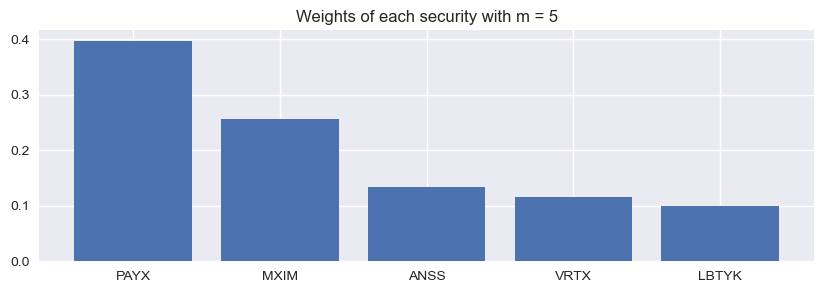

In [20]:
# Plot the weights of the portfolio
df = pd.DataFrame({'s':selected_stocks, 'w':modw.x}).sort_values(by='w', ascending=False)
plt.figure(figsize=(10,3))
plt.bar(df['s'], df['w'])
plt.title('Weights of each security with m = 5')
plt.show()

# Question 2

## Performance Analysis

In [21]:
# Best five stocks
selected_stocks = selected_stocks.tolist()
selected_stocks

['ANSS', 'LBTYK', 'MXIM', 'PAYX', 'VRTX']

In [22]:
# Portfolio Weights
weight = modw.x
weight

array([0.13389818, 0.09897376, 0.25557096, 0.39624907, 0.11530804])

In [23]:
# Evaluation data frame, which is the daily returns in 2020 for stocks we picked into the portfolio
evaluate_df = return20[['NDX']+selected_stocks].iloc[1:,:]
evaluate_df.head(5)

,NDX,ANSS,LBTYK,MXIM,PAYX,VRTX
Unnamed: 0,,,,,,
2020-01-03,-0.008827,-0.010093,-0.016204,-0.017299,-0.003407,-0.006699
2020-01-06,0.006211,-0.009262,0.015059,-0.018093,-0.000118,0.027755
2020-01-07,-0.000234,0.008170,-0.007881,0.022576,-0.005542,-0.001071
2020-01-08,0.007452,0.004130,-0.043458,-0.000325,0.009841,0.032620
2020-01-09,0.008669,0.014356,-0.024426,0.007308,0.006810,-0.003592


We evaluate the performance by calculating:
$$\sum_{t=1}^T |q_t-\sum_{i=5}^5 w_ir_{it}|$$
where $w_i$ is from our previous calculation and $q_t$, $r_{it}$ are based on 2020 data

In [24]:
# Calculate the error
T = len(evaluate_df) # Number of trading days
error = 0
for t in range(T):
    qt = evaluate_df.iloc[t,:]['NDX']  # Daily index return
    ret = evaluate_df.iloc[t,:][selected_stocks].to_list()  # Daily portfolio returns 
    error += abs(qt - np.dot(weight, ret))  # Absolute difference between the returns
error

1.9269557774066013

**The error would be 1.112%**

In [25]:
# Ploting NDX 2020 vs List of selected stocks 

selected_stocks_df=stock20[selected_stocks]
weight_list=weight_df.values.tolist()
w=[]

selected_stocks_df.head()


,ANSS,LBTYK,MXIM,PAYX,VRTX
Unnamed: 0,,,,,
2020-01-02,259.589996,21.600000,60.980679,81.750160,219.449997
2020-01-03,256.970001,21.250000,59.925747,81.471611,217.979996
2020-01-06,254.589996,21.570000,58.841522,81.461998,224.029999
2020-01-07,256.670013,21.400000,60.169949,81.010551,223.789993
2020-01-08,257.730011,20.469999,60.150410,81.807793,231.089996


In [26]:
for i in range(len(weight_list[0])):
    w.append(weight_list[0][i])
w
for i, col in enumerate(selected_stocks_df.columns):
    selected_stocks_df[col] = selected_stocks_df[col] * w[i]

selected_stocks_df.head()

,ANSS,LBTYK,MXIM,PAYX,VRTX
Unnamed: 0,,,,,
2020-01-02,34.758627,2.137833,15.584890,32.393425,25.304349
2020-01-03,34.407814,2.103192,15.315280,32.283050,25.134846
2020-01-06,34.089136,2.134864,15.038184,32.279241,25.832460
2020-01-07,34.367647,2.118038,15.377691,32.100356,25.804785
2020-01-08,34.509578,2.025993,15.372698,32.416262,26.646534


In [27]:
selected_stocks_df1=selected_stocks_df.sum(axis=1)
selected_stocks_df1

Unnamed: 0
2020-01-02    110.179124
2020-01-03    109.244183
2020-01-06    109.373885
2020-01-07    109.768517
2020-01-08    110.971065
                 ...    
2020-12-18    137.845157
2020-12-21    136.777805
2020-12-22    138.003644
2020-12-23    137.120208
2020-12-24    137.546321
Length: 249, dtype: float64

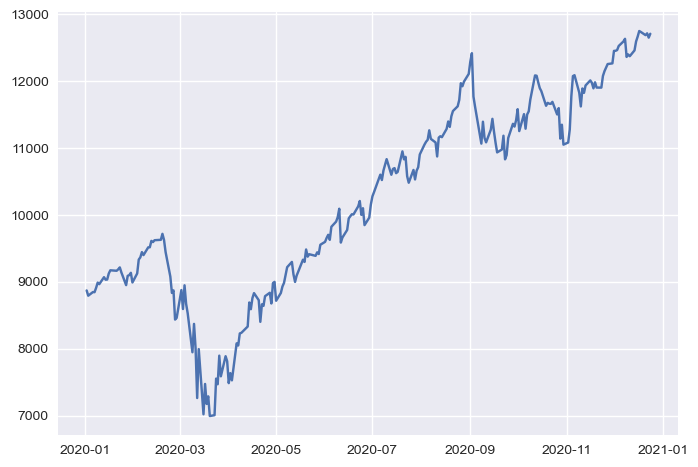

In [28]:
# plt.plot(selected_stocks_df1)
plt.plot(stock20['NDX'])
plt.plot()
plt.grid(True)
plt.show()

In [29]:
stock20.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2020-12-11', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24'],
              dtype='datetime64[ns]', name='Unnamed: 0', length=249, freq=None)

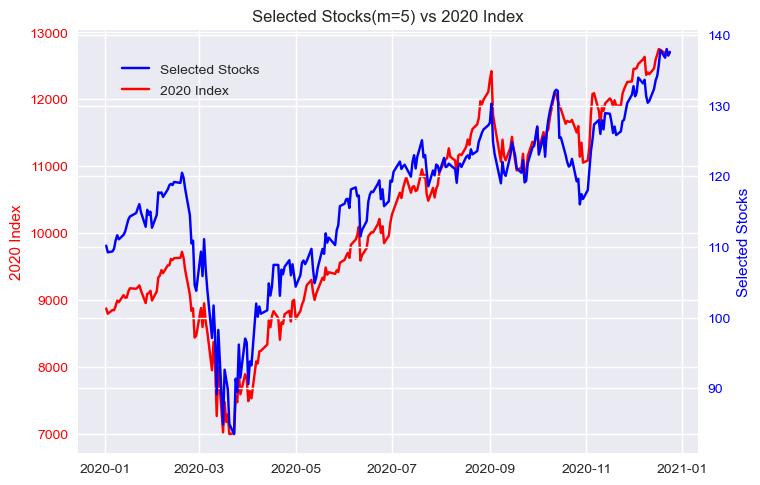

In [30]:
fig, ax1 = plt.subplots()

# Create a secondary y-axis (ax2) and plot the second data series on it
ax2 = ax1.twinx()
ax1.plot(stock20.index, stock20['NDX'], label='2020 Index', color='red', linestyle='-')
ax1.set_ylabel('2020 Index', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2.plot(selected_stocks_df1.index, selected_stocks_df1, label='Selected Stocks', color='blue', linestyle='-')
ax2.set_xlabel('X-Axis')
ax2.set_ylabel('Selected Stocks', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add legends for both series
ax1.legend(loc='upper left', bbox_to_anchor=(0.05, 0.90))
ax2.legend(loc='upper left', bbox_to_anchor=(0.05, 0.95))

# Set a title for the plot
plt.title('Selected Stocks(m=5) vs 2020 Index')

# Display the plot
plt.grid(True)
plt.show()

In [31]:
selected_stocks_df1.corr(stock20['NDX'])

0.9481165641606263

In [32]:
selected_stocks_df2=selected_stocks_df1.pct_change()
selected_stocks_df2=selected_stocks_df2.dropna()
return20_NDX=return20['NDX'].dropna()

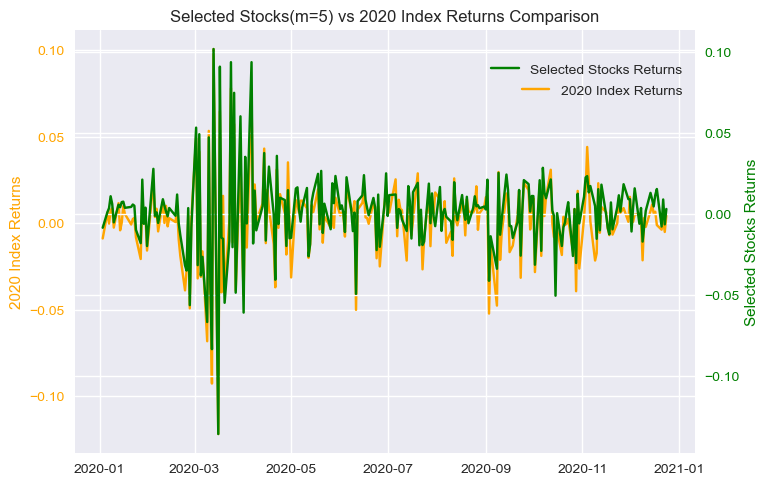

In [33]:
fig, ax1 = plt.subplots()

# Create a secondary y-axis (ax2) and plot the second data series on it
ax2 = ax1.twinx()
ax1.plot(return20_NDX.index, return20_NDX, label='2020 Index Returns', color='orange', linestyle='-')
ax1.set_ylabel('2020 Index Returns', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2.plot(selected_stocks_df2.index, selected_stocks_df2, label='Selected Stocks Returns', color='green', linestyle='-')
ax2.set_xlabel('X-Axis')
ax2.set_ylabel('Selected Stocks Returns', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends for both series
ax1.legend(loc='upper right', bbox_to_anchor=(1.0, 0.90))
ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))

# Set a title for the plot
plt.title('Selected Stocks(m=5) vs 2020 Index Returns Comparison')

# Display the plot
plt.grid(True)
plt.show()

# Question 3
Redo step (2) with m = 10, 20, ..., 90, 100. Analyze the performance of the portfolio for each value of m. How does the performance change? Is there some value of m, where there are diminishing returns of including more stocks in the portfolio? You can also look at the in- sample performance. That is, evaluate the performance in 2019 using 2019 portfolio construction and 2019 data. How is performance in 2019 different than performance in 2020? Why is it different?

In [34]:
# Create the list for multiple m
m_list = [i for i in range(10, 101, 10)]
m_list

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [35]:
# Create a dataframe to store the value and prediction error 
df = pd.DataFrame(columns=['m', 'Prediction Error'])

In [36]:
for m in m_list:
    
    # Build selection model
    select = gp.Model()
    # Decision Variables
    selectX = select.addMVar((n,n), vtype='B')
    selectY = select.addMVar(n, vtype='B')
    # Objective Function
    select.setObjective(gp.quicksum(gp.quicksum(selectX[i][j]*rho.iloc[i, j] for i in range(n)) for j in range(n)), sense=gp.GRB.MAXIMIZE)
    # Constraints
    total_con = select.addConstr(gp.quicksum(selectY[j] for j in range(n)) == m)
    row_con = select.addConstrs(gp.quicksum(selectX[i][j] for j in range(n)) == 1 for i in range(n))
    select_con = select.addConstrs(selectX[i][j]<=selectY[j] for i in range(n) for j in range(n))
    select.Params.OutputFlag = 0
    select.optimize()
    
    # Fetch the selected stocks
    Y_indices = np.where(selectY.x == 1)
    selected_stocks = rho.index[Y_indices].tolist()
    train_q = return19.iloc[:, 0].iloc[1:]
    selected_return = return19.iloc[:,(Y_indices[0]+1).tolist()].iloc[1:]
    # Build portfolio weights model
    weight = gp.Model()
    # Decision Variables
    y = weight.addMVar(T)
    w = weight.addMVar(m)
    # Objective Function
    weight.setObjective(sum(y), sense=gp.GRB.MINIMIZE)
    # Constraints
    T = return19.shape[0] - 1
    y_t = [train_q[t]-gp.quicksum(selected_return.iloc[t,i] * w[i] for i in range(m)) for t in range(T)]
    sum_con = weight.addConstr(sum(w) == 1)
    up_con = weight.addConstrs(y[t] >= y_t[t] for t in range(T))
    down_con = weight.addConstrs(y[t] >= -y_t[t] for t in range(T))
    weight.Params.OutputFlag = 0
    weight.optimize()
    
    # Portfolio Weights
    weights = w.x
    # Evaluation data frame, which is the daily returns in 2020 for stocks we picked into the portfolio
    evaluate_df = return20[['NDX']+selected_stocks].iloc[1:,:]
    # Calculate the error
    error = 0
    for t in range(T):
        qt = evaluate_df.iloc[t,:]['NDX']  # Daily index return
        ret = evaluate_df.iloc[t,:][selected_stocks].to_list()  # Daily portfolio returns 
        error += abs(qt - np.dot(weights, ret))  # Absolute difference between the returns
    
    df.loc[len(df.index)]=[m, error]
    print(df.loc[len(df.index)-1])
df

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
m                   10.000000
Prediction Error     1.680743
Name: 0, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
m                   20.000000
Prediction Error     1.018135
Name: 1, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
m                   30.00000
Prediction Error     0.86021
Name: 2, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
m                   40.000000
Prediction Error     0.922481
Name: 3, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
m                   50.000000
Prediction Error     0.872227
Name: 4, dtype: float64
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
m                   60.000000
Prediction Error     1.058148
Name: 5, dtype: float64
Warning for adding constraints

GurobiError: Unable to retrieve attribute 'x'

In [ ]:
# See the performance with 2019
# Create a dataframe to store the value and prediction error 
df_2019 = pd.DataFrame(columns=['m', 'Prediction Error'])

for m in m_list:
    
    # Build selection model
    select = gp.Model()
    # Decision Variables
    selectX = select.addMVar((n,n), vtype='B')
    selectY = select.addMVar(n, vtype='B')
    # Objective Function
    select.setObjective(gp.quicksum(gp.quicksum(selectX[i][j]*rho.iloc[i, j] for i in range(n)) for j in range(n)), sense=gp.GRB.MAXIMIZE)
    # Constraints
    total_con = select.addConstr(gp.quicksum(selectY[j] for j in range(n)) == m)
    row_con = select.addConstrs(gp.quicksum(selectX[i][j] for j in range(n)) == 1 for i in range(n))
    select_con = select.addConstrs(selectX[i][j]<=selectY[j] for i in range(n) for j in range(n))
    select.Params.OutputFlag = 0
    select.optimize()
    
    # Fetch the selected stocks
    Y_indices = np.where(selectY.x == 1)
    selected_stocks = rho.index[Y_indices].tolist()
    train_q = return19.iloc[:, 0].iloc[1:]
    selected_return = return19.iloc[:,(Y_indices[0]+1).tolist()].iloc[1:]
    # Build portfolio weights model
    weight = gp.Model()
    # Decision Variables
    y = weight.addMVar(T)
    w = weight.addMVar(m)
    # Objective Function
    weight.setObjective(sum(y), sense=gp.GRB.MINIMIZE)
    # Constraints
    T = return19.shape[0] - 1
    y_t = [train_q[t]-gp.quicksum(selected_return.iloc[t,i] * w[i] for i in range(m)) for t in range(T)]
    sum_con = weight.addConstr(sum(w) == 1)
    up_con = weight.addConstrs(y[t] >= y_t[t] for t in range(T))
    down_con = weight.addConstrs(y[t] >= -y_t[t] for t in range(T))
    weight.Params.OutputFlag = 0
    weight.optimize()
    
    # Portfolio Weights
    weights = w.x
    # Evaluation data frame, which is the daily returns in 2019 for stocks we picked into the portfolio
    evaluate_df = return19[['NDX']+selected_stocks].iloc[1:,:]
    # Calculate the error
    error = 0
    for t in range(T):
        qt = evaluate_df.iloc[t,:]['NDX']  # Daily index return
        ret = evaluate_df.iloc[t,:][selected_stocks].to_list()  # Daily portfolio returns 
        error += abs(qt - np.dot(weights, ret))  # Absolute difference between the returns
    
    df_2019.loc[len(df_2019.index)]=[m, error]
    print(df.loc[len(df_2019.index)-1])
df_2019

In [ ]:
# Plot the prediction error
plt.plot(df.index, df['Prediction Error'], label='Pred Error for NDX 2020')
plt.plot(df_2019.index, df_2019['Prediction Error'], label='Pred Error for NDX 2019')
plt.title('Prediction Error as Number of Stocks Picked Changes')
plt.xlabel('Num of Stocks in the Portfolio')
plt.ylabel('Prediction Error')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# stocks_2019 = pd.read_csv("stocks2019.csv")

# Calculate daily returns for 2019
returns_2019 = stocks_2019.iloc[:, 1:].pct_change().dropna()

# Compute the correlation matrix

rho_2019 = returns_2019.drop(columns='NDX').corr()
rho_2019.head()
# stocks_2020 = pd.read_csv("stocks2020.csv")

# Calculate daily returns for 2020
returns_2020 = stocks_2020.iloc[:, 1:].pct_change().dropna()

# Question 4

In [86]:
return20=return20.dropna()

In [92]:
GUROBI_TIME_LIMIT = 3600
M = 1.0  # Big M value

Performance_19 = {}
Performance_20 = {}
Results = {}


# Function to check if results already exist
def results_exist(m_value, filename="results.csv"):
    try:
        df = pd.read_csv(filename)
        return m_value in df['m'].values
    except FileNotFoundError:
        return False

# Function to save results to a CSV
def save_results(m_value, optimal_weights,error_2019,error_2020 ,filename="results.csv"):
    df = pd.DataFrame({"m": [m_value], "weights": [str(optimal_weights)],"2019":error_2019,"2020":error_2020})
    if results_exist(m_value, filename):
        df.to_csv(filename, mode='a', header=False, index=False)
    else:
        df.to_csv(filename, index=False)

# Looping over different m values

m_values1 = [5]
m_values2 = list(range(10, 101, 10))
m_values  = m_values1+m_values2

for m in m_values:
    print(m)
    # if results_exist(m):
    #     print(f"Results for m={m} already exist. Skipping...")
    #     continue

    mip_model = gp.Model()
    n = len(rho_2019.columns)
    T = returns_2019.shape[0]
    T2= returns_2020.shape[0]
    # Decision Variables
    w = mip_model.addMVar(n, name="weights")  # Portfolio weights for all stocks
    if m < 100:
        y = mip_model.addMVar(n, vtype='B', name="stock_selected")  # Binary variable for stock selection
        # Big M constraints
        for i in range(n):
            mip_model.addConstr(w[i] <= M * y[i])
        # Ensure only m stocks are selected
        mip_model.addConstr(gp.quicksum(y[i] for i in range(n)) == m)
    
    # Constraints and objective for minimizing the absolute difference between portfolio and index returns
    y_abs_diff = mip_model.addMVar(T, name="abs_diff")
    mip_model.setObjective(gp.quicksum(y_abs_diff[t] for t in range(T)), sense=gp.GRB.MINIMIZE)

    for t in range(T):
        portfolio_return_at_t = gp.quicksum(w[i] * returns_2019.iloc[t, i+1] for i in range(n))  
        mip_model.addConstr(y_abs_diff[t] >= returns_2019.iloc[t, 0] - portfolio_return_at_t)  
        mip_model.addConstr(y_abs_diff[t] >= -returns_2019.iloc[t, 0] + portfolio_return_at_t) 
    
    # Weights sum up to 1
    mip_model.addConstr(gp.quicksum(w[i] for i in range(n)) == 1)

    # Limit Gurobi's time for the problem
    mip_model.Params.TimeLimit = GUROBI_TIME_LIMIT
    mip_model.Params.OutputFlag = 0
    mip_model.optimize()

    # Fetch the optimal weights and print them
    optimal_weights_mip = {rho_2019.columns[i]: w[i].x for i in range(n) if (m == 100 or y[i].x > 0.5)}
    error_2019=mip_model.objVal
    
    error_2020=sum(abs(return20[['NDX']].iloc[t,0] - sum(w[i].x*return20[rho.columns].iloc[t,i] for i in range(n))) for t in range(T2))
        
  # Save the results
#     save_results(m, optimal_weights_mip)
    Results[m] = {'Portforlio Weights': optimal_weights_mip,'2019 error': error_2019,'2020 error': error_2020}
    


5
Set parameter TimeLimit to value 3600
10
Set parameter TimeLimit to value 3600
20
Set parameter TimeLimit to value 3600
30
Set parameter TimeLimit to value 3600
40
Set parameter TimeLimit to value 3600
50
Set parameter TimeLimit to value 3600
60
Set parameter TimeLimit to value 3600
70
Set parameter TimeLimit to value 3600
80
Set parameter TimeLimit to value 3600
90
Set parameter TimeLimit to value 3600
100
Set parameter TimeLimit to value 3600


In [93]:
for i in m_values:
    print(Results[i]['2019 error'])

0.4992586920546352
0.3018622466422534
0.16243297703208812
0.10564072320991849
0.08063217438393176
0.061594216476207844
0.05260483763327922
0.04757651328505543
0.04522707258836288
0.044911179824038326
0.04491081635614753


In [94]:
for i in m_values:
    print(Results[i]['2020 error'])

0.7773624845503452
0.7037147641272998
0.5879366764148758
0.5086425005677259
0.42642687335444757
0.41546239572995713
0.378357796668485
0.37868718133808316
0.3706154795877107
0.36908801438876393
0.36867085361031565


In [109]:
# Saving the results
for i in m_values:
    pd.DataFrame(Results[i]['Portforlio Weights'].items(), columns=['Stocks', 'Weights']).to_csv(f"{i} weights.csv")


In [110]:
x=[]
for i in m_values:
    x.append(Results[i]['2019 error'])

In [111]:
y=[]
for i in m_values:
    y.append(Results[i]['2020 error'])

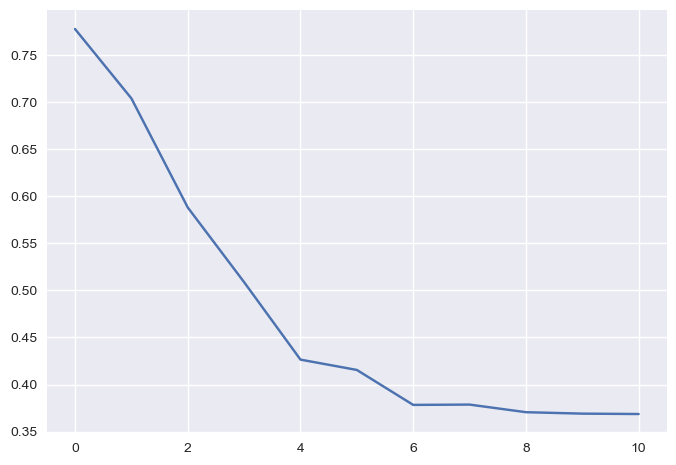

In [114]:
plt.plot(y)

In [115]:
z=[]
for i in m_values:
    z.append(i)

In [117]:
tempdf1=pd.DataFrame({'M (Number of Stocks)':z,"2019":x,"2020":y})

In [118]:
tempdf1

,M (Number of Stocks),2019,2020
0,5,0.499259,0.777362
1,10,0.301862,0.703715
2,20,0.162433,0.587937
3,30,0.105641,0.508643
4,40,0.080632,0.426427
5,50,0.061594,0.415462
6,60,0.052605,0.378358
7,70,0.047577,0.378687
8,80,0.045227,0.370615
9,90,0.044911,0.369088


In [147]:
t222=df.join(df_2019,lsuffix=' 2020',rsuffix=' 2019')

In [148]:
t222

,m 2020,Prediction Error 2020,m 2019,Prediction Error 2019
0,10.0,1.100511,10.0,0.701218
1,20.0,0.898691,20.0,0.478836
2,30.0,0.769042,30.0,0.418015
3,40.0,0.790233,40.0,0.370517
4,50.0,0.771502,50.0,0.332540
5,60.0,1.093723,60.0,0.344890
6,70.0,0.555813,70.0,0.169824
7,80.0,0.535013,80.0,0.147683
8,90.0,0.364608,90.0,0.053779
9,100.0,0.365480,100.0,0.044911


In [149]:
t222=t222.drop(['m 2019'],axis=1)
t222.rename(columns={"m 2020": "M (Number of Stocks)"})

,M (Number of Stocks),Prediction Error 2020,Prediction Error 2019
0,10.0,1.100511,0.701218
1,20.0,0.898691,0.478836
2,30.0,0.769042,0.418015
3,40.0,0.790233,0.370517
4,50.0,0.771502,0.332540
5,60.0,1.093723,0.344890
6,70.0,0.555813,0.169824
7,80.0,0.535013,0.147683
8,90.0,0.364608,0.053779
9,100.0,0.365480,0.044911


In [150]:
tempdf1.to_csv("Exporrtttt.csv")

In [ ]:
tempdf1